In [13]:
using FeedbackParticleFilters
using StatsBase
using PyPlot

# Model setup

Here, we want to do filtering for a simple stochastic harmonic oscillator which is described by the 2d system of stochastic differential equations:

$$ dX_t = V_t dt, $$
$$ dV_t = -a X_t dt - b V_t dt + \sqrt{2} dW_t, $$

where $X_t$ is the position and $V_t$ is the velocity of the harmonic oscillator.
We assume that the system's velocity is observed linearly in Gaussian white noise, i.e.

$$ dY_t = V_t dt + dB_t. $$

## Define state model

We use the constructor for a linear diffusion process in order to define the model.

In [2]:
A = [0. 1.; -0.7 -0.1]
B = zeros(2,1)
B[2,1] = sqrt(2.);

In [3]:
st_mod = LinearDiffusionStateModel(A, B, [2., 0.])

Linear diffusion process model for the hidden state
    type of hidden state:                   2-dimensional vector
    number of independent Brownian motions: 1
    initial condition:                      fixed

## Define observation model

In [4]:
C = [0. 1.;]

1×2 Array{Float64,2}:
 0.0  1.0

In [5]:
ob_mod = LinearDiffusionObservationModel(C)

Linear diffusion process model for the observation
    type of hidden state:                   2-dimensional vector
    type of observation:                    1-dimensional vector
    number of independent Brownian motions: 1

## Define filtering problem

In [6]:
filt_prob = FilteringProblem(st_mod, ob_mod)

ContinuousTime - ContinuousTime filtering problem
    hidden state model:                     2-dimensional linear diffusion with 1-dimensional Brownian motion
    observation model:                      1-dimensional linear diffusion with 1-dimensional Brownian motion
    hidden state type:                      Array{Float64,1}
    observation type:                       Array{Float64,1}

# Filtering

We solve this filtering problem by two different methods: an exact Kalman-Bucy filter (KBF) and an approximate feedback particle filter (FPF).
The FPF is known to be equivalent to the KBF in the limit of large $N$ (number of particles).

## Kalman-Bucy filter

The following code automatically constructs a KBF for the filtering problem above:

In [7]:
kbf = KBF(filt_prob)

KBF{Array{Float64,2},Array{Float64,2},Array{Float64,2},Array{Float64,2},KBState{MultivariateGaussian{Float64,Array{Float64,1},Array{Float64,2}}}}([0.0 1.0; -0.7 -0.1], [0.0 0.0; 0.0 2.0], [0.0 1.0], [0.0 0.0; 0.0 1.0], KBState{MultivariateGaussian{Float64,Array{Float64,1},Array{Float64,2}}}(MultivariateGaussian{Float64,Array{Float64,1},Array{Float64,2}}([2.0, 0.0], [0.0 0.0; 0.0 0.0])))

We set up a simulation for the filtering problem, KBF, for a 100000 time steps of size 0.01:

In [8]:
kbf_simulation = ContinuousTimeSimulation(filt_prob, kbf, 100000, 0.01)

Continuous-time simulation
    filtering problem:                      ContinuousTime - ContinuousTime with LinearDiffusionStateModel and LinearDiffusionObservationModel
    filtering algorithm:                    KBF{Array{Float64,2},Array{Float64,2},Array{Float64,2},Array{Float64,2},KBState{MultivariateGaussian{Float64,Array{Float64,1},Array{Float64,2}}}}([0.0 1.0; -0.7 -0.1], [0.0 0.0; 0.0 2.0], [0.0 1.0], [0.0 0.0; 0.0 1.0], KBState{MultivariateGaussian{Float64,Array{Float64,1},Array{Float64,2}}}(MultivariateGaussian{Float64,Array{Float64,1},Array{Float64,2}}([2.0, 0.0], [0.0 0.0; 0.0 0.0])))
    number of time steps:                   100000
    size of time step:                      0.01

We want to record the true position of the simulated harmonic oscillator $X_t$, its estimate $E[X_t|\mathcal{F}_t^Y]$, and its conditional standard deviation.
To do this, we define three functions:

In [39]:
hs(x)  = hidden_state(x)[1]
cm(x)  = cond_mean(x)[1]
std(x) = sqrt(cond_var(x)[1,1]);

In [26]:
@time kbf_output = run!(kbf_simulation, records = (hs, cm, std, ob))

  0.753220 seconds (7.42 M allocations: 493.146 MiB, 27.08% gc time)


4×100000 Array{Any,2}:
 2.0        2.00003     2.00285    …  -0.0506581  -0.0481822  -0.0463519
 2.0        1.99986     1.99953       -2.8797     -2.87697    -2.87295  
 0.0        0.0         0.0019999      1.37204     1.37204     1.37204  
 0.094918  -0.0259746  -0.244272      -0.100063    0.0855082  -0.0140436

We plot the first 30000 time steps of this output:

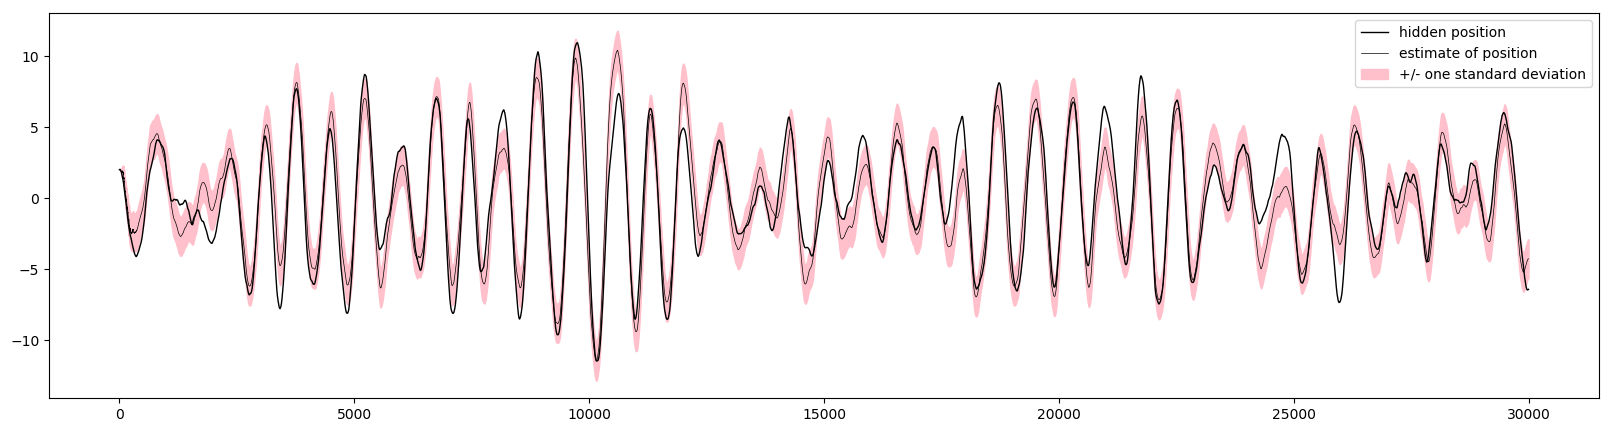

PyObject <matplotlib.legend.Legend object at 0x7f6c5d0ecc50>

In [38]:
rng = 1:30000
figure(figsize=(20,5))
plot(rng, kbf_output[1,rng], lw = 1, color = "black");
plot(rng, kbf_output[2,rng], lw = 0.5, color = "black");
fill_between(1:n_time, kbf_output[2,rng] + kbf_output[3,rng], kbf_output[2,rng] - kbf_output[3,rng], color = "pink")
legend(["hidden position", "estimate of position","+/- one standard deviation"])

## Feedback particle filter

Again, we define the appropriate filter for our problem.
We need to supply two additional arguments for the gain estimation method and the number of particles:

In [42]:
fpf = FPF(filt_prob, ConstantGainApproximation(), 100)

Feedback particle filter algorithm
    hidden state model:                     2-dimensional linear diffusion with 1-dimensional Brownian motion
    observation model:                      1-dimensional linear diffusion with 1-dimensional Brownian motion
    ensemble size:                          100
    gain estimation method:                 ConstantGainApproximation()

In [49]:
fpf_simulation = ContinuousTimeSimulation(filt_prob, fpf, 100000, 0.01)

Continuous-time simulation
    filtering problem:                      ContinuousTime - ContinuousTime with LinearDiffusionStateModel and LinearDiffusionObservationModel
    filtering algorithm:                    FPF with 100 particles and ConstantGainApproximation()
    number of time steps:                   100000
    size of time step:                      0.01

The previously defined functions are generic and also work for the present case. naturally, this simulation takes a bit longer than the previous one.

In [50]:
@time fpf_output = run!(fpf_simulation, records = (hs, cm, std));

  5.632015 seconds (70.90 M allocations: 3.815 GiB, 15.68% gc time)


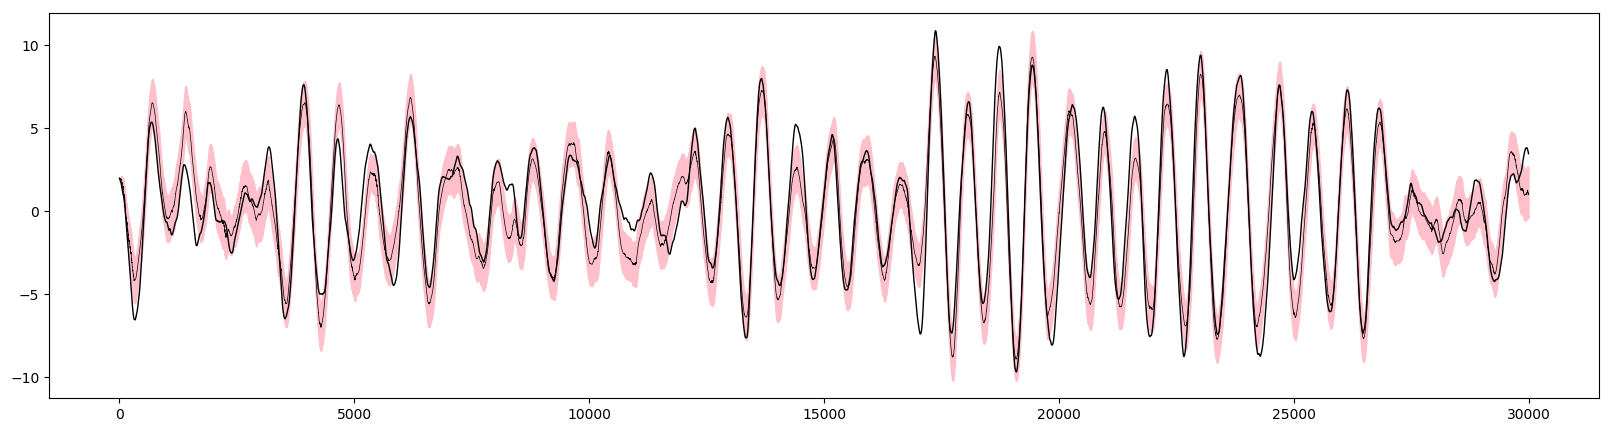

In [51]:
using PyPlot
rng = 1:30000
figure(figsize=(20,5))
plot(rng, fpf_output[1,rng], lw = 1, color = "black");
plot(rng, fpf_output[2,rng], lw = 0.5, color = "black");
fill_between(rng, fpf_output[2,rng] + fpf_output[3,rng], fpf_output[2,rng] - fpf_output[3,rng], color = "pink")
#plot(rng, 10fpf_output[4,rng], lw = 0.1, color = "green");
#plot(rng, 2 .+ cumsum(fpf_output[4,rng]), lw = 0.4, color = "blue");